# Preliminary analysis of all user rating histories

In [1]:
%matplotlib inline
%load_ext rpy2.ipython

import requests
import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir

In [2]:
df_rhist = pd.DataFrame.from_csv('rating_histories.csv')

In [3]:
grouped = df_rhist.groupby('handle')
cnt = 0

ncontests=[]
time=[]
rankchange=[]

for name, group in grouped:
    #group['time'] = group.ratingUpdateTimeSeconds - min(group.ratingUpdateTimeSeconds)
    idx_start = group.index[0]
    idx_end = group.index[-1]
    time.append(group.ratingUpdateTimeSeconds[idx_end] - group.ratingUpdateTimeSeconds[idx_start])
    ncontests.append(len(group))
    rankchange.append(group.newRating[idx_end] - group.newRating[idx_start])
    
    #rankchange.append(group.newRating[len(group)] - group.newRating[0])
    #print group
    
#for name, group in grouped:
#    print name
#    print group
#    break


In [4]:
# Look at autocorrelation between each time point in each person's rating history
acor = []

for name, group in grouped:
    delta = group.newRating - group.oldRating
    acor.append(pd.Series.autocorr(delta))

In [5]:
# Use a sliding window to smooth out rating histories
# 0 1 2 3 4 5 6 7 8 9
# |pre----|
#           |post---| 
#   |pre----|
#             |post---| 
slidingCor = []
slidingWindow = 5
handles = []

for name, group in grouped:
    handles.append(name)
    
    ratingDeltas = list(group.newRating - group.oldRating)
    
    pre = []
    post = []
    nwindows = len(ratingDeltas) - 2*slidingWindow + 1
    if nwindows < 3:
        continue
    for i in range(nwindows):
        pre.append(sum(ratingDeltas[i:(i+slidingWindow)])) 
        post.append(sum(ratingDeltas[(i+slidingWindow) : (i+2*slidingWindow)]))
        #print i, i+slidingWindow, " vs ", i + slidingWindow, i + 2*slidingWindow
    
    cor = pd.Series.corr(pd.Series(pre), pd.Series(post))
    slidingCor.append(cor)

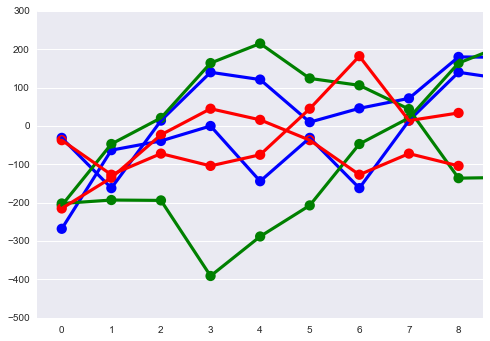

In [39]:
colors = ['blue', 'green', 'red']
j = 0
for handle, scor in zip(handles, slidingCor):
    if scor <= -.999:
        group = grouped.get_group(handle)
        
        ratingDeltas = list(group.newRating - group.oldRating)

        pre = []
        post = []
        nwindows = len(ratingDeltas) - 2*slidingWindow + 1
        for i in range(nwindows):
            pre.append(sum(ratingDeltas[i:(i+slidingWindow)])) 
            post.append(sum(ratingDeltas[(i+slidingWindow) : (i+2*slidingWindow)]))
            
        sns.pointplot(range(len(pre)),pre, color=colors[j])   
        sns.pointplot(range(len(pre)),post, color=colors[j])   
#        sns.pointplot(group.ratingUpdateTimeSeconds,group.newRating, color=colors[i])
        j += 1
#        ratingDeltas = list(group.newRating - group.oldRating)
#        print ratingDeltas
#        for i in range(len(ratingDeltas)-9):
#            pre = sum(ratingDeltas[i:i+5])
#            post = sum(ratingDeltas[i+5:i+10])
#            print pre, post

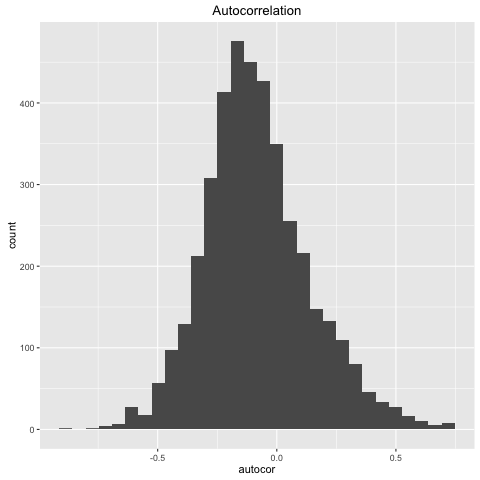

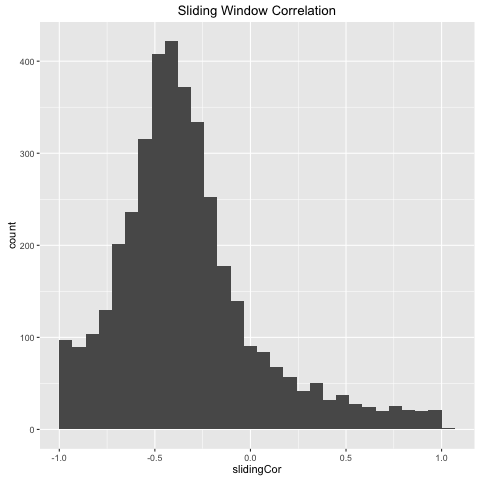

In [50]:
%%R -i ncontests -i time -i rankchange -i acor -i slidingCor
library(ggplot2)
df <- data.frame(contests = ncontests, time = time, ratingChange = rankchange, autocor = acor)
slidingdf <- data.frame(slidingCor = slidingCor)

df$logcontests = log(ncontests)
fit <- lm(ratingChange ~ logcontests, data = df)
#str(summary(fit))
summary(fit)$r.squared
#summary(fit)$coefficients

c <- ggplot(df)
c <- c + geom_histogram(aes(x=autocor)) + labs(title='Autocorrelation')
print(c)
#c + geom_point(aes(x = log(contests), y = ratingChange), alpha=0.2)
#c + geom_point(aes(x = log(time), y = ratingChange), alpha=0.2)

ggplot(slidingdf) + geom_histogram(aes(x=slidingCor)) + labs(title='Sliding Window Correlation')

In [5]:
# for each user, we want to normalize times to when they first started


,contestName,handle,newRating,oldRating,rank,ratingUpdateTimeSeconds
contestId,,,,,,
659,Codeforces Round #346 (Div. 2),Hedgehogy,292,372,3594,1459362900
669,"Codeforces Round #348 (VK Cup 2016 Round 2, Di...",Hedgehogy,222,292,2073,1461522900
670,Codeforces Round #350 (Div. 2),Hedgehogy,152,222,3230,1462473300
673,"Codeforces Round #351 (VK Cup 2016 Round 3, Di...",Hedgehogy,71,152,2328,1462644300
672,Codeforces Round #352 (Div. 2),Hedgehogy,14,71,3200,1462991700
